In [1]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/ZUHveJKajnZNwTA/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet
!wget https://cernbox.cern.ch/remote.php/dav/public-files/ZUHveJKajnZNwTA/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet
!wget https://cernbox.cern.ch/remote.php/dav/public-files/ZUHveJKajnZNwTA/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet

--2024-03-29 07:47:32--  https://cernbox.cern.ch/remote.php/dav/public-files/ZUHveJKajnZNwTA/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.170.17, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184115523 (176M) [application/octet-stream]
Saving to: 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'

QCDToGGQQ_IMGjet_RH 100%[===================>] 175.59M  13.7MB/s    in 15s     

2024-03-29 07:47:51 (12.0 MB/s) - 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet' saved [184115523/184115523]

--2024-03-29 07:47:52--  https://cernbox.cern.ch/remote.php/dav/public-files/ZUHveJKajnZNwTA/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (

In [6]:
import time
import numpy as np
import cv2
import pyarrow.parquet as pq
import os
from sklearn.model_selection import train_test_split

start_time = time.time()

def generate(pf, path, ab):
    record_batch = pf.iter_batches(batch_size=4 * 1024)
    while True:
        try:
            batch = next(record_batch)
            ab = transform(batch, path, ab)
        except StopIteration:
            return ab

def transform(batch, path, ab):
    p = batch.to_pandas()
    im = np.array(np.array(np.array(p.iloc[:, 0].tolist()).tolist()).tolist())
    meta = np.array(p.iloc[:, 3])
    return saver(im, meta, path, ab)

def saver(im, meta, path, ab):
    alpha, beta = ab
    im[im < 1.e-3] = 0
    for i in range(3):
        im[:, i, :, :] = (im[:, i, :, :] - im[:, i, :, :].mean()) / (im[:, i, :, :].std())
        im[:, i, :, :] = np.clip(im[:, i, :, :], 0, 500 * im[:, i, :, :].std())
        im[:, i, :, :] = 255 * (im[:, i, :, :] / im[:, i, :, :].max())
    images, labels = [], []
    for i in range(meta.shape[0]):
        img = im[i].astype(np.uint8).transpose(1, 2, 0)
        label = meta[i]
        images.append(img)
        labels.append(label)
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
    for img, label in zip(train_images, train_labels):
        if label == 0:
            impath = os.path.join(path, "train", "0", f"{alpha}.png")
            alpha += 1
        elif label == 1:
            impath = os.path.join(path, "train", "1", f"{beta}.png")
            beta += 1
        cv2.imwrite(impath, img)
    for img, label in zip(val_images, val_labels):
        if label == 0:
            impath = os.path.join(path, "validation", "0", f"{alpha}.png")
            alpha += 1
        elif label == 1:
            impath = os.path.join(path, "validation", "1", f"{beta}.png")
            beta += 1
        cv2.imwrite(impath, img)
    return [alpha, beta]

def runner(source_files, target_directory):
    ab = [0, 0]
    for file in source_files:
        parquet_file_path = os.path.join('/kaggle/working/', file)
        ab = generate(pq.ParquetFile(parquet_file_path), target_directory, ab)
    print("Data generation completed")
input_files = [
    'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    'QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]
output_directory = '/kaggle/working/output/'
for folder in ['train', 'validation']:
    for class_label in ['0', '1']:
        os.makedirs(os.path.join(output_directory, folder, class_label), exist_ok=True)
runner(source_files=input_files, target_directory=output_directory)
end_time = time.time()
running_time = end_time - start_time
print(f"Time: {running_time} seconds")

Data generation completed
Time: 520.3923428058624 seconds


In [9]:
os.listdir("/kaggle/working/output/train/1")[1]

'23628.png'

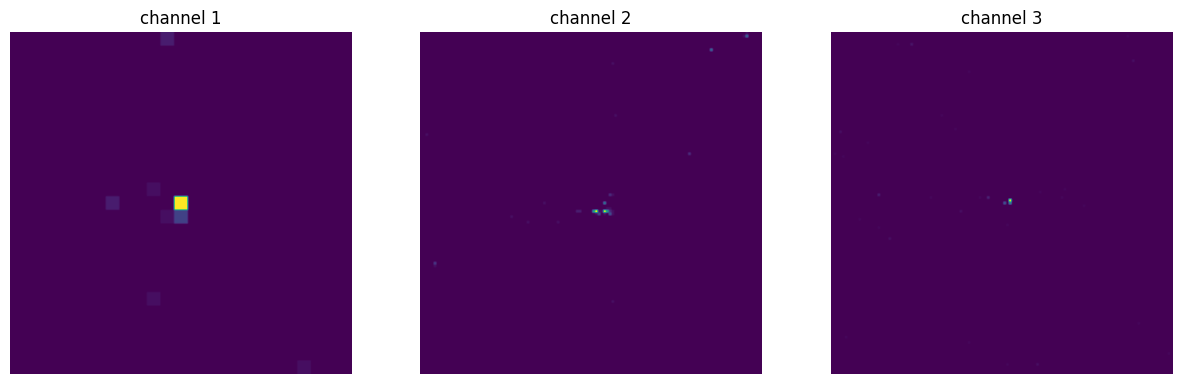

In [11]:
#Visualizing a sample
import matplotlib.pyplot as plt
a = plt.imread("/kaggle/working/output/train/1/23628.png")

channel_1 = a[:, :, 0]
channel_2 = a[:, :, 1]
channel_3 = a[:, :, 2]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(channel_1, cmap='viridis')
axes[0].set_title('channel 1')
axes[0].axis('off')
axes[1].imshow(channel_2, cmap='viridis')
axes[1].set_title('channel 2')
axes[1].axis('off')
axes[2].imshow(channel_3, cmap='viridis')
axes[2].set_title('channel 3')
axes[2].axis('off')
plt.show()

In [14]:
!rm -rf /kaggle/working/output/0 && rm -rf /kaggle/working/output/1 

In [ ]:
#Saving the data as zip
def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

output_directory = '/kaggle/working/output'
zip_file_path = '/kaggle/working/output.zip'
zip_folder(output_directory, zip_file_path)